In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from PIL import Image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf

seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
import seaborn as sns

tf_chkpt_path = 'tf_TransferLearning_8Classes'

In [4]:
from src.helperFunctions import display_model_trainTestGraphs

In [5]:
# import tensorflow as tf
# tf.config.list_physical_devices()

# Training Set

In [24]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=2,
    color_mode='rgb',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [25]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=10,
    color_mode='rgb',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [26]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

In [27]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 20,
                           restore_best_weights=True,
                           mode='min')

In [28]:
csv_logger = CSVLogger('Logger.log', separator=',', append=False)

In [29]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >100:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
    
    
lr_schd_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
best_model = ModelCheckpoint(tf_chkpt_path+'_best_model.hdf5', 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             save_freq='epoch')

# VGG 16

In [31]:
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    classes=7,
    classifier_activation='softmax',
    input_shape=(227,227,3),
)


In [32]:
model = tf.keras.Sequential([
  vgg,
  layers.Flatten(),
    layers.Dense(8, activation='softmax')
])


model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy',
#                        Precision(),
#                        Recall()
                       ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 8)                 200712    
                                                                 
Total params: 14,915,400
Trainable params: 14,915,400
Non-trainable params: 0
_________________________________________________________________


In [33]:
results = model.fit(train_generator,
                    steps_per_epoch=75,
                    epochs=500,  # Number of epochs
                    validation_data=val_generator,
                    #                                         validation_steps=50,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
                        #                         early_stop,
                        best_model
                    ]
                    )

Epoch 1/500
75/75 [==============================] - ETA: 0s - loss: 1.0817 - accuracy: 0.6933
Epoch 1: val_loss improved from inf to 0.83848, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 59s 787ms/step - loss: 1.0817 - accuracy: 0.6933 - val_loss: 0.8385 - val_accuracy: 0.7910 - lr: 1.0000e-05
Epoch 2/500
75/75 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.8267
Epoch 2: val_loss improved from 0.83848 to 0.79386, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 59s 794ms/step - loss: 0.6544 - accuracy: 0.8267 - val_loss: 0.7939 - val_accuracy: 0.7915 - lr: 1.0000e-05
Epoch 3/500
75/75 [==============================] - ETA: 0s - loss: 0.7857 - accuracy: 0.7718
Epoch 3: val_loss did not improve from 0.79386
75/75 [==============================] - 59s 799ms/step - loss: 0.7857 - accuracy: 0.7718 - val_loss: 0.8009 - val_accuracy: 0.7991 - lr: 1.0000e-05

Epoch 27/500
75/75 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.9067
Epoch 27: val_loss did not improve from 0.46658
75/75 [==============================] - 59s 796ms/step - loss: 0.3651 - accuracy: 0.9067 - val_loss: 0.4806 - val_accuracy: 0.8588 - lr: 8.4366e-06
Epoch 28/500
75/75 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.9067
Epoch 28: val_loss did not improve from 0.46658
75/75 [==============================] - 59s 795ms/step - loss: 0.2666 - accuracy: 0.9067 - val_loss: 0.7088 - val_accuracy: 0.7677 - lr: 8.3527e-06
Epoch 29/500
75/75 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8867
Epoch 29: val_loss did not improve from 0.46658
75/75 [==============================] - 59s 794ms/step - loss: 0.2974 - accuracy: 0.8867 - val_loss: 0.6130 - val_accuracy: 0.8425 - lr: 8.2696e-06
Epoch 30/500
75/75 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.8733
Epoch 30: val_loss did no

75/75 [==============================] - 59s 800ms/step - loss: 0.2358 - accuracy: 0.9400 - val_loss: 0.3827 - val_accuracy: 0.8831 - lr: 6.4404e-06
Epoch 55/500
75/75 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9533
Epoch 55: val_loss did not improve from 0.38266
75/75 [==============================] - 59s 795ms/step - loss: 0.1035 - accuracy: 0.9533 - val_loss: 0.4192 - val_accuracy: 0.8751 - lr: 6.3763e-06
Epoch 56/500
75/75 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9333
Epoch 56: val_loss did not improve from 0.38266
75/75 [==============================] - 59s 799ms/step - loss: 0.2261 - accuracy: 0.9333 - val_loss: 0.4364 - val_accuracy: 0.8692 - lr: 6.3128e-06
Epoch 57/500
75/75 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9533
Epoch 57: val_loss did not improve from 0.38266
75/75 [==============================] - 59s 792ms/step - loss: 0.1346 - accuracy: 0.9533 - val_loss: 0.4788 - val_accura

75/75 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9667
Epoch 82: val_loss did not improve from 0.36599
75/75 [==============================] - 59s 792ms/step - loss: 0.1138 - accuracy: 0.9667 - val_loss: 0.4417 - val_accuracy: 0.8762 - lr: 4.8675e-06
Epoch 83/500
75/75 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9267
Epoch 83: val_loss did not improve from 0.36599
75/75 [==============================] - 58s 789ms/step - loss: 0.2005 - accuracy: 0.9267 - val_loss: 0.4171 - val_accuracy: 0.8783 - lr: 4.8191e-06
Epoch 84/500
75/75 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9467
Epoch 84: val_loss did not improve from 0.36599
75/75 [==============================] - 59s 791ms/step - loss: 0.1841 - accuracy: 0.9467 - val_loss: 0.3984 - val_accuracy: 0.8796 - lr: 4.7711e-06
Epoch 85/500
75/75 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9400
Epoch 85: val_loss did not improve fro

75/75 [==============================] - 59s 793ms/step - loss: 0.1280 - accuracy: 0.9733 - val_loss: 0.4022 - val_accuracy: 0.8895 - lr: 4.0252e-06
Epoch 110/500
75/75 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9800
Epoch 110: val_loss did not improve from 0.35739
75/75 [==============================] - 59s 796ms/step - loss: 0.0937 - accuracy: 0.9800 - val_loss: 0.3741 - val_accuracy: 0.8945 - lr: 4.0252e-06
Epoch 111/500
75/75 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9267
Epoch 111: val_loss did not improve from 0.35739
75/75 [==============================] - 59s 795ms/step - loss: 0.2737 - accuracy: 0.9267 - val_loss: 0.4090 - val_accuracy: 0.8835 - lr: 4.0252e-06
Epoch 112/500
75/75 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9400
Epoch 112: val_loss did not improve from 0.35739
75/75 [==============================] - 59s 796ms/step - loss: 0.1869 - accuracy: 0.9400 - val_loss: 0.4220 - val_

75/75 [==============================] - 59s 793ms/step - loss: 0.1151 - accuracy: 0.9600 - val_loss: 0.4919 - val_accuracy: 0.8637 - lr: 4.0252e-06
Epoch 137/500
75/75 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9733
Epoch 137: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 791ms/step - loss: 0.0949 - accuracy: 0.9733 - val_loss: 0.3798 - val_accuracy: 0.8904 - lr: 4.0252e-06
Epoch 138/500
75/75 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9600
Epoch 138: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.1144 - accuracy: 0.9600 - val_loss: 0.5266 - val_accuracy: 0.8801 - lr: 4.0252e-06
Epoch 139/500
75/75 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9733
Epoch 139: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 791ms/step - loss: 0.0815 - accuracy: 0.9733 - val_loss: 0.4860 - val_

75/75 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9867
Epoch 164: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 794ms/step - loss: 0.0941 - accuracy: 0.9867 - val_loss: 0.4534 - val_accuracy: 0.8750 - lr: 4.0252e-06
Epoch 165/500
75/75 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9667
Epoch 165: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 792ms/step - loss: 0.0966 - accuracy: 0.9667 - val_loss: 0.3889 - val_accuracy: 0.8884 - lr: 4.0252e-06
Epoch 166/500
75/75 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9600
Epoch 166: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.1026 - accuracy: 0.9600 - val_loss: 0.4615 - val_accuracy: 0.8763 - lr: 4.0252e-06
Epoch 167/500
75/75 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9600
Epoch 167: val_loss did not impr

Epoch 192/500
75/75 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9667
Epoch 192: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.0924 - accuracy: 0.9667 - val_loss: 0.4217 - val_accuracy: 0.8891 - lr: 4.0252e-06
Epoch 193/500
75/75 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9867
Epoch 193: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.0944 - accuracy: 0.9867 - val_loss: 0.4348 - val_accuracy: 0.8838 - lr: 4.0252e-06
Epoch 194/500
75/75 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9733
Epoch 194: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 794ms/step - loss: 0.0740 - accuracy: 0.9733 - val_loss: 0.3705 - val_accuracy: 0.8986 - lr: 4.0252e-06
Epoch 195/500
75/75 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9600
Epoch 195: val_los

Epoch 220/500
75/75 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9200
Epoch 220: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.1755 - accuracy: 0.9200 - val_loss: 0.4156 - val_accuracy: 0.8808 - lr: 4.0252e-06
Epoch 221/500
75/75 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9467
Epoch 221: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 791ms/step - loss: 0.1691 - accuracy: 0.9467 - val_loss: 0.4207 - val_accuracy: 0.8773 - lr: 4.0252e-06
Epoch 222/500
75/75 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9667
Epoch 222: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.0778 - accuracy: 0.9667 - val_loss: 0.5186 - val_accuracy: 0.8747 - lr: 4.0252e-06
Epoch 223/500
75/75 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9600
Epoch 223: val_los

Epoch 248/500
75/75 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9667
Epoch 248: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 794ms/step - loss: 0.1148 - accuracy: 0.9667 - val_loss: 0.3917 - val_accuracy: 0.8931 - lr: 4.0252e-06
Epoch 249/500
75/75 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9467
Epoch 249: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 795ms/step - loss: 0.1291 - accuracy: 0.9467 - val_loss: 0.4316 - val_accuracy: 0.8753 - lr: 4.0252e-06
Epoch 250/500
75/75 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9867
Epoch 250: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 794ms/step - loss: 0.0471 - accuracy: 0.9867 - val_loss: 0.4170 - val_accuracy: 0.8897 - lr: 4.0252e-06
Epoch 251/500
75/75 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9800
Epoch 251: val_los

Epoch 276/500
75/75 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9400
Epoch 276: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 794ms/step - loss: 0.2044 - accuracy: 0.9400 - val_loss: 0.5027 - val_accuracy: 0.8765 - lr: 4.0252e-06
Epoch 277/500
75/75 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9867
Epoch 277: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 793ms/step - loss: 0.0972 - accuracy: 0.9867 - val_loss: 0.4360 - val_accuracy: 0.8847 - lr: 4.0252e-06
Epoch 278/500
75/75 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9600
Epoch 278: val_loss did not improve from 0.33575
75/75 [==============================] - 59s 795ms/step - loss: 0.1187 - accuracy: 0.9600 - val_loss: 0.3979 - val_accuracy: 0.8921 - lr: 4.0252e-06
Epoch 279/500
75/75 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9800
Epoch 279: val_los

Epoch 304/500
75/75 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9867
Epoch 304: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 795ms/step - loss: 0.0687 - accuracy: 0.9867 - val_loss: 0.3804 - val_accuracy: 0.8961 - lr: 4.0252e-06
Epoch 305/500
75/75 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9733
Epoch 305: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 793ms/step - loss: 0.0806 - accuracy: 0.9733 - val_loss: 0.4091 - val_accuracy: 0.8908 - lr: 4.0252e-06
Epoch 306/500
75/75 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9133
Epoch 306: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 794ms/step - loss: 0.1854 - accuracy: 0.9133 - val_loss: 0.4048 - val_accuracy: 0.8865 - lr: 4.0252e-06
Epoch 307/500
75/75 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9733
Epoch 307: val_los

Epoch 332/500
75/75 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9400
Epoch 332: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 795ms/step - loss: 0.1681 - accuracy: 0.9400 - val_loss: 0.3928 - val_accuracy: 0.8970 - lr: 4.0252e-06
Epoch 333/500
75/75 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9867
Epoch 333: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 794ms/step - loss: 0.0358 - accuracy: 0.9867 - val_loss: 0.4147 - val_accuracy: 0.8959 - lr: 4.0252e-06
Epoch 334/500
75/75 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9667
Epoch 334: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 796ms/step - loss: 0.1496 - accuracy: 0.9667 - val_loss: 0.3574 - val_accuracy: 0.9008 - lr: 4.0252e-06
Epoch 335/500
75/75 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9667
Epoch 335: val_los

Epoch 360/500
75/75 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9867
Epoch 360: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 796ms/step - loss: 0.0396 - accuracy: 0.9867 - val_loss: 0.4311 - val_accuracy: 0.8909 - lr: 4.0252e-06
Epoch 361/500
75/75 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9867
Epoch 361: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 793ms/step - loss: 0.0629 - accuracy: 0.9867 - val_loss: 0.5133 - val_accuracy: 0.8871 - lr: 4.0252e-06
Epoch 362/500
75/75 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9667
Epoch 362: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 797ms/step - loss: 0.0485 - accuracy: 0.9667 - val_loss: 0.4457 - val_accuracy: 0.8958 - lr: 4.0252e-06
Epoch 363/500
75/75 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9600
Epoch 363: val_los

Epoch 388/500
75/75 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9467
Epoch 388: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 795ms/step - loss: 0.1264 - accuracy: 0.9467 - val_loss: 0.3497 - val_accuracy: 0.8992 - lr: 4.0252e-06
Epoch 389/500
75/75 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9667
Epoch 389: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 792ms/step - loss: 0.1047 - accuracy: 0.9667 - val_loss: 0.3426 - val_accuracy: 0.8983 - lr: 4.0252e-06
Epoch 390/500
75/75 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9600
Epoch 390: val_loss did not improve from 0.32870
75/75 [==============================] - 59s 795ms/step - loss: 0.0934 - accuracy: 0.9600 - val_loss: 0.3728 - val_accuracy: 0.8983 - lr: 4.0252e-06
Epoch 391/500
75/75 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 1.0000
Epoch 391: val_los

75/75 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9600
Epoch 415: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 792ms/step - loss: 0.1129 - accuracy: 0.9600 - val_loss: 0.3962 - val_accuracy: 0.8947 - lr: 4.0252e-06
Epoch 416/500
75/75 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9733
Epoch 416: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 795ms/step - loss: 0.1044 - accuracy: 0.9733 - val_loss: 0.3576 - val_accuracy: 0.9010 - lr: 4.0252e-06
Epoch 417/500
75/75 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9733
Epoch 417: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 793ms/step - loss: 0.0774 - accuracy: 0.9733 - val_loss: 0.3551 - val_accuracy: 0.9024 - lr: 4.0252e-06
Epoch 418/500
75/75 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9667
Epoch 418: val_loss did not impr

Epoch 443/500
75/75 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9533
Epoch 443: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 793ms/step - loss: 0.1164 - accuracy: 0.9533 - val_loss: 0.4340 - val_accuracy: 0.8789 - lr: 4.0252e-06
Epoch 444/500
75/75 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9933
Epoch 444: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 796ms/step - loss: 0.0456 - accuracy: 0.9933 - val_loss: 0.3917 - val_accuracy: 0.8991 - lr: 4.0252e-06
Epoch 445/500
75/75 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9600
Epoch 445: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 792ms/step - loss: 0.0796 - accuracy: 0.9600 - val_loss: 0.3641 - val_accuracy: 0.8953 - lr: 4.0252e-06
Epoch 446/500
75/75 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9667
Epoch 446: val_los

Epoch 471/500
75/75 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9867
Epoch 471: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 794ms/step - loss: 0.0347 - accuracy: 0.9867 - val_loss: 0.4083 - val_accuracy: 0.8973 - lr: 4.0252e-06
Epoch 472/500
75/75 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9867
Epoch 472: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 796ms/step - loss: 0.0399 - accuracy: 0.9867 - val_loss: 0.4319 - val_accuracy: 0.8947 - lr: 4.0252e-06
Epoch 473/500
75/75 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9600
Epoch 473: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 793ms/step - loss: 0.1156 - accuracy: 0.9600 - val_loss: 0.3928 - val_accuracy: 0.8931 - lr: 4.0252e-06
Epoch 474/500
75/75 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9733
Epoch 474: val_los

Epoch 499/500
75/75 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9800
Epoch 499: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 795ms/step - loss: 0.0699 - accuracy: 0.9800 - val_loss: 0.4415 - val_accuracy: 0.8928 - lr: 4.0252e-06
Epoch 500/500
75/75 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9800
Epoch 500: val_loss did not improve from 0.32161
75/75 [==============================] - 59s 796ms/step - loss: 0.0699 - accuracy: 0.9800 - val_loss: 0.4236 - val_accuracy: 0.8985 - lr: 4.0252e-06


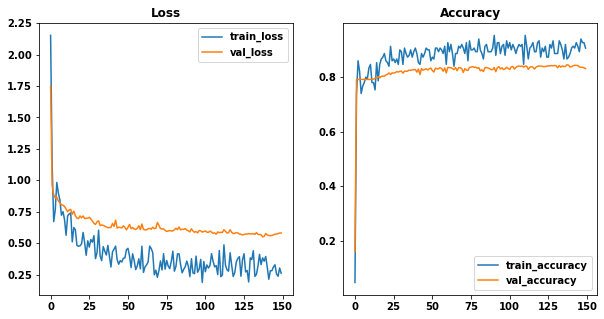

In [16]:
display_model_trainTestGraphs(results)

In [34]:
m = models.load_model('tf_TransferLearning_8Classes_best_model.hdf5')

In [35]:
m.evaluate(val_generator)

1418/1418 [==============================] - 58s 40ms/step - loss: 0.3216 - accuracy: 0.9101


[0.32161274552345276, 0.9100528955459595]

In [36]:
m.evaluate(test_generator)

1793/1793 [==============================] - 14s 8ms/step - loss: 0.3871 - accuracy: 0.9236


[0.3870948553085327, 0.9235917329788208]

In [20]:
test_generator.class_indices

{'bright dune': 0,
 'crater': 1,
 'dark dune': 2,
 'impact ejecta': 3,
 'other': 4,
 'slope streak': 5,
 'spider': 6,
 'swiss cheese': 7}